In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
print(torch.cuda.is_available())  # Should print True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary
from tqdm import tqdm

True


In [ ]:
#Global Variable For training
Batch_Size=100
Num_Epoch=2
Learning_Rate=0.01
Criterion=nn.CrossEntropyLoss()
Optimizer=torch.optim.Adam

In [ ]:
#CIFARIO Dataset
Train_dataset=dsets.CIFAR10(root='./data',train=True,transform=transforms.ToTensor(),download=True)
Test_dataset=dsets.CIFAR10(root='./data',train=False,transform=transforms.ToTensor(),download=True)

Train_loader=DataLoader(dataset=Train_dataset,batch_size=Batch_Size,shuffle=True)
Test_loader=DataLoader(dataset=Test_dataset,batch_size=Batch_Size,shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 45.4MB/s]


In [ ]:
def fit(model, train_loader):
    model.train()
    device = next(model.parameters()).device.index
    optimizer = torch.optim.SGD(model.parameters(), lr=Learning_Rate, momentum=0.9)
    losses = []
    for i, data in enumerate(train_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)
        pred = model(image)
        loss = Criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return sum(losses) / len(losses)

def eval(model, test_loader):
    model.eval()
    device = next(model.parameters()).device.index
    pred_labels = []
    real_labels = []
    for i, data in enumerate(test_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)
        pred_label = model(image)
        pred_label = torch.argmax(pred_label, dim=1)
        pred_labels += pred_label.tolist()
        real_labels += label.tolist()
    real_labels = np.array(real_labels)
    pred_labels = np.array(pred_labels)
    return sum(real_labels == pred_labels) / len(real_labels) * 100

In [ ]:
# VGG
import torch.utils.model_zoo as model_zoo

model_urls = {
    'vgg11':'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13':'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16':'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19':'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn':'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn':'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn':'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn':'https://download.pytorch.org/models/vgg19_bn-903'

}

In [ ]:
# VGG class definition: handles feature extraction and classification
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):

        super(VGG, self).__init__()

        self.features = features  # CNN feature extractor built by make_layers()

        self.classifier = nn.Sequential(  # Fully connected (dense) layers
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
        )

        if init_weights:
            self._initialize_weights()  # Initialize weights if specified


    def forward(self, x):
        x = self.features(x)           # Apply convolutional layers
        x = x.view(x.size(0), -1)      # Flatten the output
        x = self.classifier(x)         # Apply dense layers
        return x


    def _initialize_weights(self):
        for m in self.modules(): # Iterate through all modules
            if isinstance(m, nn.Conv2d):  # For Conv2d layers, use He initialization
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):  # For BatchNorm, set weight=1 and bias=0
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):  # For linear layers, use normal distribution
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)




# Helper function to build VGG convolutional layers based on configuration
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3  # CIFAR images have 3 color channels (RGB)

    for v in cfg:
        if v == 'M':
            # 'M' means MaxPooling layer
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

        else:
            # Create a Conv2d layer with 3x3 kernel
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)

            if batch_norm:
                # Add BatchNorm and ReLU if batch normalization is enabled
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]

            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v  # Update input channels for next layer


    return nn.Sequential(*layers)



# Configuration dictionary: defines different VGG model architectures
cfg = {'A':[64,'M',128,'M',256,256,'M',512,512,'M',512,512,'M'],
       'B':[64,64,'M',128,128,'M',256,256,'M',512,512,'M',512,512,'M'],
       'D':[64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M'],
       'E':[64,64,'M',128,128,'M',256,256,256,256,'M',512,512,512,512,'M',512,512,512,512,'M']}



# VGG model builders for different architectures (with optional pretrained weights)
def vgg11(pretrained=False, **kwargs):

    if pretrained:
      kwargs['init_weights']=False
    model = VGG(make_layers(cfg['A']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11']))
    return model

def vgg11_bn(pretrained=False, **kwargs):

    if pretrained:
      kwargs['init_weights']=False
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn']))
    return model

def vgg13(pretrained=False, **kwargs):

    if pretrained:
      kwargs['init_weights']=False
    model = VGG(make_layers(cfg['B']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg13']))
    return model

def vgg13_bn(pretrained=False, **kwargs):

    if pretrained:
      kwargs['init_weights']=False
    model =  VGG(make_layers(cfg['B'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg13_bn']))
    return model

def vgg16(pretrained=False, **kwargs):

    if pretrained:
      kwargs['init_weights']=False
    model = VGG(make_layers(cfg['D']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16']))
    return model

def vgg16_bn(passtrained=False, **kwargs):

    if pretrained:
      kwargs['init_weights']=False
    model = VGG(make_layers(cfg['D'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16_bn']))
    return model

def vgg19(pretrained=False, **kwargs):

    if pretrained:
      kwargs['init_weights']=False
    model = VGG(make_layers(cfg['E']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19']))
    return model

def vgg19_bn(passtrained=False, **kwargs):

    if pretrained:
      kwargs['init_weights']=False
    model = VGG(make_layers(cfg['E'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg19_bn']))
    return model

In [ ]:
vgg_model = vgg11_bn(num_classes=10).cuda()

train_loss2=[]
test_acc2=[]
for epoch in tqdm(range(Num_Epoch)):
  train_loss2.append(fit(vgg_model,Train_loader))
  test_acc2.append(eval(vgg_model,Test_loader))
summary(vgg_model,(3,32,32))

100%|██████████| 2/2 [00:44<00:00, 22.30s/it]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

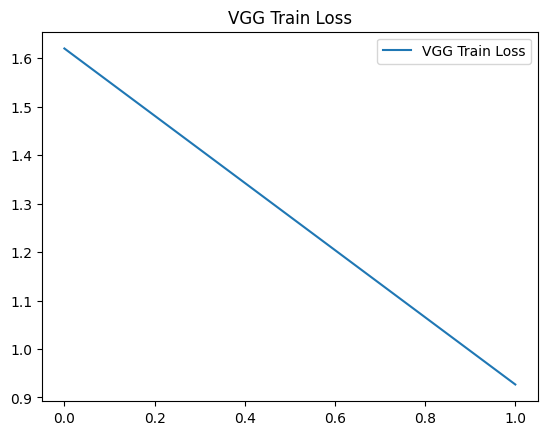

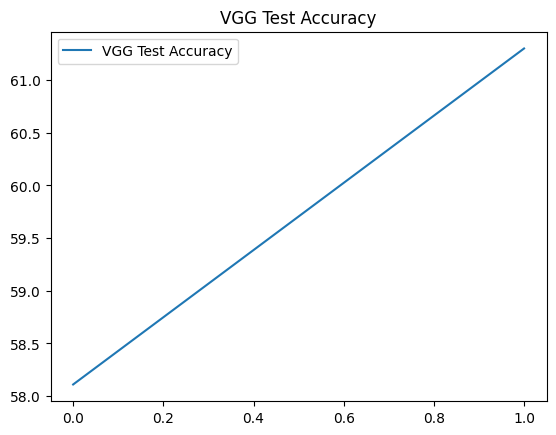

In [ ]:
plt.plot(train_loss2, label='VGG Train Loss')
plt.legend()
plt.title('VGG Train Loss')
plt.show()

plt.plot(test_acc2, label='VGG Test Accuracy')
plt.legend()
plt.title('VGG Test Accuracy')
plt.show()